In [1]:
import os 
from Bio import SeqIO
import pickle
import numpy as np

import tensorflow as tf
import tensorflow.keras.backend as K

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score

import math

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [11]:
##################################################################################
##### Define all parameters for model tuning
##################################################################################

n_fold = 10
expName = "biLSTM_AE_Setting1"
outPath = "Generated"
foldName = "folds.pickle"

modelNames = ["Bi_LSTM_AE"]

epochs = 30
batch_size = 64
shuffle = False
seed = None

dataset_path = "CORENup-Datasets\\Datasets"
setting = "Setting1"


In [4]:
##################################################################################
##### Checking the directory
##################################################################################

dataset_setting_path = os.path.join(dataset_path, setting)
dataset_varieties = next(os.walk(dataset_setting_path))
print(dataset_varieties)

('CORENup-Datasets\\Datasets\\Setting1', ['Drosophila', 'Elegans', 'Homo_Sapiens', 'Yeast'], [])


In [5]:
##################################################################################
##### define custom one hot encoding, contains code from repository
##################################################################################

def one_hot_encode(sequence):
    
    seq_encoded = np.zeros((len(sequence),4))
    dict_nuc = {
        "A": 0,
        "C": 1,
        "G": 2,
        "T":3
    }
    i = 0
    
    for single_character in sequence:
        if(single_character.upper() in dict_nuc.keys()):
            seq_encoded[i][dict_nuc[single_character.upper()]] = 1
            i = i+1
        else:
            return []
    
    return seq_encoded

##################################################################################
##### define K-fold building functions
##################################################################################

def build_kfold(features, labels, k=10, shuffle=False, seed=None):
    
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        kfoldList.append({
            "X_train": X_train,
            "X_test": X_test,
            "y_train":y_train,
            "y_test":y_test
        })
    return kfoldList

##################################################################################
##### prediction encoding functions
##################################################################################

def row_convert(row):
    return (row == row.max(axis=1)[:,None]).astype(float)

def pred2label_AE(y_pred):
    return np.array([row_convert(row) for row in y_pred])

def pred2label(y_pred):
    y_pred = np.round(np.clip(y_pred, 0, 1))
    return y_pred

##################################################################################
##### custom reconstruction accuracy function
##################################################################################

def one_hot_decode_integer(sequence):
    return np.argmax(sequence, axis=1)

def average_reconstruction_accuracy(y_true, y_pred_label):
    if len(y_true) == len(y_pred_label):
        acc_scores = [accuracy_score(one_hot_decode_integer(pair[0]), one_hot_decode_integer(pair[1])) for pair in zip(y_true, y_pred_label)]
        return np.mean(acc_scores)

In [6]:
##################################################################################
##### Functions to customize the LSTM AE network
##################################################################################

def biLSTM_AutoEncoder(input_shape = (150,4),
                       lstm_decode_units = 100, ## LSTM layer 1 parameters
                       learn_rate = 0.001, loss = 'categorical_crossentropy', metrics = None):

    inputs = tf.keras.Input(shape=input_shape)
    
    encoded = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = lstm_decode_units,
                                                                 activation='softmax', 
                                                                 return_sequences = True))(inputs)

    # encoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))(encoded)
    encoded = tf.keras.layers.Dense(units = 1)(encoded)
    
    # decoded = tf.keras.layers.RepeatVector(input_shape[0])(encoded)
    decoded = tf.keras.layers.LSTM(units=lstm_decode_units, return_sequences=True)(encoded)
    decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=input_shape[1], activation='sigmoid'))(decoded)
    
    sequence_autoencoder = tf.keras.Model(inputs, decoded)
    encoder = tf.keras.Model(inputs, encoded)
    
    sequence_autoencoder.compile(optimizer = tf.keras.optimizers.Adam(lr = learn_rate), loss = loss)
    
    return sequence_autoencoder, encoder

##################################################################################
##### Functions to customize a simple fully-connected classification network
##################################################################################

def FFNN_Classifier(input_shape=(150,1), 
                    dense_decode_units = 150,
                    learn_rate = 0.01, prob = 0.1, loss = 'binary_crossentropy', metrics = None):
    
    # beta = 0.001
    
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape = input_shape))
    # model.add(tf.keras.layers.Dense(dense_decode_units, kernel_regularizer=tf.keras.regularizers.l2(beta), activation='relu'))
    model.add(tf.keras.layers.Dense(dense_decode_units*2, activation='relu'))
    # model.add(tf.keras.layers.BatchNormalization(trainable = True))
    # model.add(tf.keras.layers.Dropout(prob))
    # model.add(tf.keras.layers.Dense(dense_decode_units*2, kernel_regularizer=tf.keras.regularizers.l2(beta), activation='relu'))
    model.add(tf.keras.layers.Dense(dense_decode_units, activation='relu'))
    # model.add(tf.keras.layers.BatchNormalization(trainable = True))
    # model.add(tf.keras.layers.Dropout(prob))
    # model.add(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(beta), activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    #[tf.keras.metrics.binary_accuracy, metrics.precision, metrics.recall, metrics.f1score])
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(lr = learn_rate), loss = loss, metrics = metrics) 
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(lr = learn_rate), loss = loss)

    return model

In [21]:
folds[0]['X_train'].shape

(3258, 150, 4)

In [7]:
##################################################################################
##### For each input file, train model and generate different outputs in a structured folder
##################################################################################

## create the evaluation data structure for all iterations
evaluations = {
    "Model" : [],
    "Dataset" : [],
    "Fold" : [],
    "AutoEncoder_Categorical_CrossEntropy_Loss" : [],
    "AutoEncoder_Reconstruction_Accuracy" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

i = 0

for root, dirs, files in os.walk(dataset_setting_path):
    for file in files:
        
        current_dataset_variety = root.split("\\")[len(root.split("\\"))-1]
        
        ##################################################################################
        ##### read the current file
        ##################################################################################
        
        openFile = open(os.path.join(root, file))
        fastaSequences = SeqIO.parse(openFile, "fasta")
        
        ##################################################################################
        ##### extract data from the current fasta file
        ##################################################################################
        
        nucleosomal_List = []
        linker_List = []
        nucleosomal_onehotencoded_List = []
        linker_onehotencoded_List = []
        
        for fasta in fastaSequences: 
            name, sequence = fasta.id, str(fasta.seq)
            if "nucleosomal" in name:
                nucleosomal_List.append(sequence)
                aus_seq = one_hot_encode(sequence)
                if(len(aus_seq) != 0):
                    nucleosomal_onehotencoded_List.append(aus_seq)
            else:
                linker_List.append(sequence)
                aus_seq = one_hot_encode(sequence)
                if(len(aus_seq) != 0):
                    linker_onehotencoded_List.append(aus_seq)
        
        print("\n======================================================================")
        print("\nFile: "+os.path.join(root, file))
        print("Nucleosomi: "+str(len(nucleosomal_onehotencoded_List)))
        print("Linker: "+str(len(linker_onehotencoded_List)))
        
        ##################################################################################
        ##### Generate Folds from dataset, and store to file
        ##################################################################################
        
        ## create the features and labels datasets for the training
        input_size = (len(nucleosomal_onehotencoded_List[1]), 4)
        labels = np.concatenate((np.ones((len(nucleosomal_onehotencoded_List), 1), dtype=np.float32), np.zeros((len(linker_onehotencoded_List), 1), dtype=np.float32)), axis=0)
        features = np.concatenate((nucleosomal_onehotencoded_List,linker_onehotencoded_List), 0)

        ## Generate the k-fold dataset
        folds = build_kfold(features, labels, k=n_fold, shuffle=shuffle, seed=seed)
        
        ## Write the k-fold dataset to file
        foldPath = os.path.join(outPath, expName, current_dataset_variety, "{}fold".format(n_fold))
        
        ##### ADDITIONAL CHANGES - USE PREVIOUS GENERATED FOLDS IF AVAILABLE
        
        if(os.path.isfile(os.path.join(foldPath, foldName))):
            folds = pickle.load(open(os.path.join(foldPath, foldName), "rb"))
        else:
            if(not os.path.isdir(foldPath)):
                os.makedirs(foldPath)
            pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))
        
        ##################################################################################
        ##### TRAIN and PREDICT for every Fold, using both models (DLNN3 and DLNN5)
        ##################################################################################
        
        for modelName in modelNames:
            
            ## Create and set directory to save model
            modelPath = os.path.join(outPath, expName, current_dataset_variety, "{}fold".format(n_fold), "models", modelName)
            if(not os.path.isdir(modelPath)):
                os.makedirs(modelPath)
            
            ## fold counter
            i = 0

            for fold in folds:
                
                print("\nTrain/Test model "+modelName+" on Fold #"+str(i)+".")
                
                ## Generate AUTOENCODER model using function
                ae_model, encoder = biLSTM_AutoEncoder(input_shape = input_size, lstm_decode_units=150)
                
                ## Define the model callbacks for early stopping and saving the model. Then train model
                modelCallbacks = [
                    tf.keras.callbacks.ModelCheckpoint(os.path.join(modelPath, "{}_{}_bestModel-fold{}.hdf5".format(modelName, "AutoEncoder", i)),
                                                       monitor = 'val_loss', verbose = 0, save_best_only = True, 
                                                       save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
                    tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 0, 
                                                     mode = 'auto', baseline = None, restore_best_weights = False)
                ]
                ae_model.fit(x = fold["X_train"], y = fold["X_train"], batch_size = batch_size, epochs = epochs, verbose = 0,
                             callbacks = modelCallbacks, validation_data = (fold["X_test"], fold["X_test"]))
                
                ## dump Encoder to hdf5
                encoder.save(os.path.join(modelPath, "{}_{}_bestModel-fold{}.hdf5".format(modelName, "Encoder", i)))
                
                ## Generate embeddings using Encoder model
                X_train_encoded = encoder.predict(fold['X_train'])
                X_test_encoded = encoder.predict(fold['X_test'])
                
                X_train_encoded = X_train_encoded.reshape((X_train_encoded.shape[0], X_train_encoded.shape[1]))
                X_test_encoded = X_test_encoded.reshape((X_test_encoded.shape[0], X_test_encoded.shape[1]))
                
                ## Generate CLASSIFIER model using function
                model = FFNN_Classifier(input_shape = (X_train_encoded.shape[1]), dense_decode_units = X_train_encoded.shape[1], learn_rate = 0.005)
                
                ## Define the model callbacks for early stopping and saving the model. Then train model
                modelCallbacks = [
                    tf.keras.callbacks.ModelCheckpoint(os.path.join(modelPath, "{}_{}_bestModel-fold{}.hdf5".format(modelName, "Classifier", i)),
                                                       monitor = 'val_loss', verbose = 0, save_best_only = True, 
                                                       save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
                    tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 0, 
                                                     mode = 'auto', baseline = None, restore_best_weights = False)
                ]
                model.fit(x = X_train_encoded, y = fold["y_train"],
                          batch_size = batch_size, epochs = 100, verbose = 0,
                          validation_data = (X_test_encoded, fold["y_test"]),
                          callbacks = modelCallbacks)
                
                ##################################################################################
                ##### Autoencoder metrics for TRAIN dataset
                ##################################################################################
                
                x_pred = ae_model.predict(fold['X_train'])
                x_pred_label = pred2label_AE(x_pred)
                cce = tf.keras.losses.CategoricalCrossentropy()
                evaluations["AutoEncoder_Categorical_CrossEntropy_Loss"].append(cce(fold['X_train'], x_pred).numpy())
                evaluations["AutoEncoder_Reconstruction_Accuracy"].append(average_reconstruction_accuracy(fold['X_train'], x_pred_label))
                
                ##################################################################################
                ##### Prediction and metrics for TRAIN dataset
                ##################################################################################
                
                y_pred = model.predict(X_train_encoded)
                label_pred = pred2label(y_pred)
                # Compute precision, recall, sensitivity, specifity, mcc
                acc = accuracy_score(fold["y_train"], label_pred)
                prec = precision_score(fold["y_train"],label_pred)

                conf = confusion_matrix(fold["y_train"], label_pred)
                if(conf[0][0]+conf[1][0]):
                    sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
                else:
                    sens = 0.0
                if(conf[1][1]+conf[0][1]):
                    spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
                else:
                    spec = 0.0
                if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
                    mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
                else:
                    mcc= 0.0
                fpr, tpr, thresholds = roc_curve(fold["y_train"], y_pred)
                auc = roc_auc_score(fold["y_train"], y_pred)

                evaluations["Model"].append(modelName)
                evaluations["Dataset"].append(current_dataset_variety)
                evaluations["Fold"].append(i)
                evaluations["Train_Test"].append("Train")
                evaluations["Accuracy"].append(acc)
                evaluations["Precision"].append(prec)
                evaluations["TPR"].append(tpr)
                evaluations["FPR"].append(fpr)
                evaluations["TPR_FPR_Thresholds"].append(thresholds)
                evaluations["AUC"].append(auc)
                evaluations["Sensitivity"].append(sens)
                evaluations["Specificity"].append(spec)
                evaluations["MCC"].append(mcc)
                
                ##################################################################################
                ##### Autoencoder metrics for TEST dataset
                ##################################################################################
                
                x_pred = ae_model.predict(fold['X_test'])
                x_pred_label = pred2label_AE(x_pred)
                cce = tf.keras.losses.CategoricalCrossentropy()
                evaluations["AutoEncoder_Categorical_CrossEntropy_Loss"].append(cce(fold['X_test'], x_pred).numpy())
                evaluations["AutoEncoder_Reconstruction_Accuracy"].append(average_reconstruction_accuracy(fold['X_test'], x_pred_label))
                
                ##################################################################################
                ##### Prediction and metrics for TEST dataset
                ##################################################################################

                y_pred = model.predict(X_test_encoded)
                label_pred = pred2label(y_pred)
                # Compute precision, recall, sensitivity, specifity, mcc
                acc = accuracy_score(fold["y_test"], label_pred)
                prec = precision_score(fold["y_test"],label_pred)

                conf = confusion_matrix(fold["y_test"], label_pred)
                if(conf[0][0]+conf[1][0]):
                    sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
                else:
                    sens = 0.0
                if(conf[1][1]+conf[0][1]):
                    spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
                else:
                    spec = 0.0
                if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
                    mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
                else:
                    mcc= 0.0
                fpr, tpr, thresholds = roc_curve(fold["y_test"], y_pred)
                auc = roc_auc_score(fold["y_test"], y_pred)
                
                evaluations["Model"].append(modelName)
                evaluations["Dataset"].append(current_dataset_variety)
                evaluations["Fold"].append(i)
                evaluations["Train_Test"].append("Test")
                evaluations["Accuracy"].append(acc)
                evaluations["Precision"].append(prec)
                evaluations["TPR"].append(tpr)
                evaluations["FPR"].append(fpr)
                evaluations["TPR_FPR_Thresholds"].append(thresholds)
                evaluations["AUC"].append(auc)
                evaluations["Sensitivity"].append(sens)
                evaluations["Specificity"].append(spec)
                evaluations["MCC"].append(mcc)

                i = i+1
                del ae_model
                del model
                del encoder
                tf.keras.backend.clear_session()
                
##################################################################################
##### Dump evaluations to a file
##################################################################################

evalPath = os.path.join(outPath, expName, "_Evaluation_All_Datasets")
if(not os.path.isdir(evalPath)):
    os.makedirs(evalPath)

pickle.dump(evaluations,
            open(os.path.join(evalPath, "{}fold_evaluations_{}.pickle".format(n_fold, modelNames[0])), "wb"))



File: CORENup-Datasets\Datasets\Setting1\Drosophila\nucleosomes_vs_linkers_melanogaster.fas
Nucleosomi: 2900
Linker: 2850

Train/Test model Bi_LSTM_AE on Fold #0.

Train/Test model Bi_LSTM_AE on Fold #1.

Train/Test model Bi_LSTM_AE on Fold #2.

Train/Test model Bi_LSTM_AE on Fold #3.

Train/Test model Bi_LSTM_AE on Fold #4.

Train/Test model Bi_LSTM_AE on Fold #5.

Train/Test model Bi_LSTM_AE on Fold #6.

Train/Test model Bi_LSTM_AE on Fold #7.

Train/Test model Bi_LSTM_AE on Fold #8.

Train/Test model Bi_LSTM_AE on Fold #9.


File: CORENup-Datasets\Datasets\Setting1\Elegans\nucleosomes_vs_linkers_elegans.fas
Nucleosomi: 2567
Linker: 2608

Train/Test model Bi_LSTM_AE on Fold #0.

Train/Test model Bi_LSTM_AE on Fold #1.

Train/Test model Bi_LSTM_AE on Fold #2.

Train/Test model Bi_LSTM_AE on Fold #3.

Train/Test model Bi_LSTM_AE on Fold #4.



Train/Test model Bi_LSTM_AE on Fold #5.

Train/Test model Bi_LSTM_AE on Fold #6.

Train/Test model Bi_LSTM_AE on Fold #7.

Train/Test model Bi_LSTM_AE on Fold #8.

Train/Test model Bi_LSTM_AE on Fold #9.


File: CORENup-Datasets\Datasets\Setting1\Homo_Sapiens\nucleosomes_vs_linkers_sapiens.fas
Nucleosomi: 2273
Linker: 2300

Train/Test model Bi_LSTM_AE on Fold #0.

Train/Test model Bi_LSTM_AE on Fold #1.

Train/Test model Bi_LSTM_AE on Fold #2.

Train/Test model Bi_LSTM_AE on Fold #3.

Train/Test model Bi_LSTM_AE on Fold #4.

Train/Test model Bi_LSTM_AE on Fold #5.

Train/Test model Bi_LSTM_AE on Fold #6.

Train/Test model Bi_LSTM_AE on Fold #7.

Train/Test model Bi_LSTM_AE on Fold #8.

Train/Test model Bi_LSTM_AE on Fold #9.




File: CORENup-Datasets\Datasets\Setting1\Yeast\nucleosomes_vs_linkers_yeast.fas
Nucleosomi: 1880
Linker: 1740

Train/Test model Bi_LSTM_AE on Fold #0.

Train/Test model Bi_LSTM_AE on Fold #1.

Train/Test model Bi_LSTM_AE on Fold #2.

Train/Test model Bi_LSTM_AE on Fold #3.

Train/Test model Bi_LSTM_AE on Fold #4.

Train/Test model Bi_LSTM_AE on Fold #5.

Train/Test model Bi_LSTM_AE on Fold #6.

Train/Test model Bi_LSTM_AE on Fold #7.

Train/Test model Bi_LSTM_AE on Fold #8.

Train/Test model Bi_LSTM_AE on Fold #9.


## Visualization of Evaluation

In [8]:
##################################################################################
##### Add import statement here, to make this next part of code standalone executable
##################################################################################

import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import numpy as np
import pandas as pd
import math


In [9]:
# ##################################################################################
# ##### Parameters used only in this section
# ##################################################################################

# n_fold = 10
# expName = "LSTM_AE_Setting1"
# outPath = "Generated"

# modelNames = ["Bi_LSTM_AE"]

In [12]:
##################################################################################
##### Load file and convert to dataframe for easy manipulation
##################################################################################

evalPath = os.path.join(outPath, expName, "_Evaluation_All_Datasets")
if(not os.path.isdir(evalPath)):
    os.makedirs(evalPath)

evaluations = pickle.load(open(os.path.join(evalPath, "{}fold_evaluations_{}.pickle".format(n_fold, modelNames[0])), "rb"))

evaluations_df = pd.DataFrame.from_dict(evaluations)

In [13]:
##################################################################################
##### Group dataset (mean of metrics) by [Dataset, Model, Train_Test] combinations
##################################################################################

evaluations_df_grouped = evaluations_df.groupby(["Dataset", 
                                                 "Model", 
                                                 "Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC',
                                                                               'AutoEncoder_Categorical_CrossEntropy_Loss',
                                                                               'AutoEncoder_Reconstruction_Accuracy'])

Eval_Train = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(2), ['Train'])]
Eval_Test = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(2), ['Test'])]

In [14]:
##################################################################################
##### Decide on metric to visualize
##################################################################################

print("Metrics Available : ")
print(list(evaluations_df_grouped.columns))

Metrics Available : 
['Accuracy', 'Precision', 'AUC', 'Sensitivity', 'Specificity', 'MCC', 'AutoEncoder_Categorical_CrossEntropy_Loss', 'AutoEncoder_Reconstruction_Accuracy']


#### Select a metric to plot below:

In [15]:
metric_to_plot = "Accuracy"

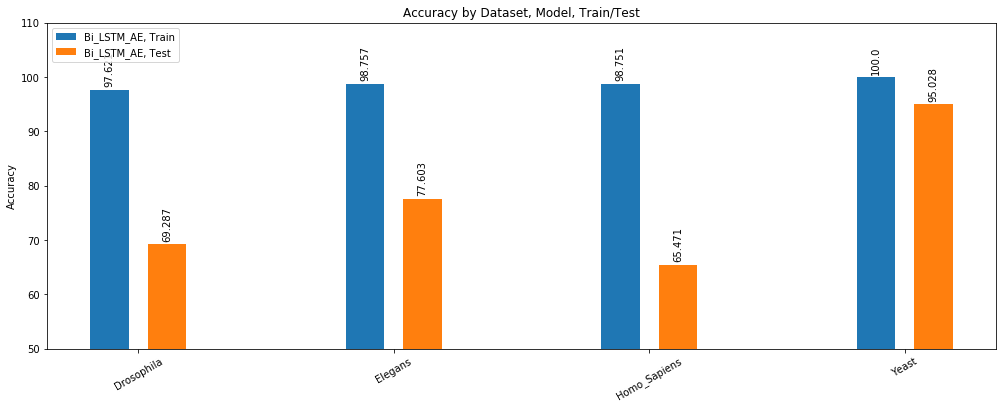

In [16]:
##################################################################################
##### Visualize with a multiple Bar chart
##################################################################################

x = np.arange(len(Eval_Train[metric_to_plot]))
width = 0.15

fig, ax = plt.subplots(figsize=(17,6))
rects1 = ax.bar(x - (1.5*(width/2)), round(Eval_Train[metric_to_plot]*100, 3), width, label='Bi_LSTM_AE, Train')
rects3 = ax.bar(x + (1.5*(width/2)), round(Eval_Test[metric_to_plot]*100, 3), width, label='Bi_LSTM_AE, Test')

## Custom y-axis tick labels
ax.set_ylabel(metric_to_plot)
ax.set_ylim([(math.floor(min(evaluations_df_grouped[metric_to_plot])*10)-1)*10, 
            (math.ceil(max(evaluations_df_grouped[metric_to_plot])*10)+1)*10])
# ax.set_ylim([80, 105])

## Custom x-axis tick labels
ax.set_xticks(x)
# ax.set_xticklabels(DLNN_3_Train.index.get_level_values(0))
# ax.set_xticklabels([m+" - "+str(n) for m,n in 
#                         zip(DLNN_CORENup_Train.index.get_level_values(0),DLNN_CORENup_Train.index.get_level_values(1))],
#                   rotation=30)
ax.set_xticklabels(Eval_Train.index.get_level_values(0),
                  rotation=30)


ax.set_title(metric_to_plot+' by Dataset, Model, Train/Test')
ax.legend(loc='upper left')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", 
                    ha='center', va='bottom', rotation=90)

autolabel(rects1)
autolabel(rects3)

plt.show()

### Store all metrics' plots to file

In [17]:
##################################################################################
##### Iteratively generate comparison plot using every metric
##################################################################################

for metric_to_plot in list(evaluations_df_grouped.columns):
    
    x = np.arange(len(Eval_Train[metric_to_plot]))
    width = 0.15

    fig, ax = plt.subplots(figsize=(17,6))
    rects1 = ax.bar(x - (1.5*(width/2)), round(Eval_Train[metric_to_plot]*100, 3), width, label='Bi_LSTM_AE, Train')
    rects3 = ax.bar(x + (1.5*(width/2)), round(Eval_Test[metric_to_plot]*100, 3), width, label='Bi_LSTM_AE, Test')

    ## Custom y-axis tick labels
    ax.set_ylabel(metric_to_plot)
    ax.set_ylim([(math.floor(min(evaluations_df_grouped[metric_to_plot])*10)-1)*10, 
                (math.ceil(max(evaluations_df_grouped[metric_to_plot])*10)+1)*10])
    # ax.set_ylim([80, 105])

    ## Custom x-axis tick labels
    ax.set_xticks(x)
    # ax.set_xticklabels(DLNN_3_Train.index.get_level_values(0))
    # ax.set_xticklabels([m+" - "+str(n) for m,n in 
    #                         zip(DLNN_CORENup_Train.index.get_level_values(0),DLNN_CORENup_Train.index.get_level_values(1))],
    #                   rotation=30)
    ax.set_xticklabels(Eval_Train.index.get_level_values(0),
                      rotation=30)


    ax.set_title(metric_to_plot+' by Dataset, Model, Train/Test')
    ax.legend(loc='upper left')

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points", 
                        ha='center', va='bottom', rotation=90)

    autolabel(rects1)
    autolabel(rects3)
    
    plt.savefig(os.path.join(evalPath, "{}_{}_Comparison".format(metric_to_plot, modelNames[0])))
    plt.close()
    